# **Assignment2_Part1_Implementing CNN architectures for image classification**
**Ya-Wen Tu 13415536 , May. 2021**

## **Step1:Data Preparation**

**Import required packages**

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

**Load Data**

In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Unzip data
!unzip '/content/gdrive/MyDrive/42028/Assignment/2/archive.zip'

串流輸出內容已截斷至最後 5000 行。
  inflating: fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Tra

In [4]:
!ls

fruits-360  gdrive  sample_data


In [5]:
#setting directory
#Load the directory paths to the dataset
data_dir = '/content/fruits-360'
train_dir = '/content/fruits-360/Training'
test_dir = '/content/fruits-360/Test'

print('Folders :\n', os.listdir(data_dir))

types = os.listdir(data_dir + "/Training")
print(len(types), ' types of fruits in Training set: \n', types)

types = os.listdir(data_dir + "/Test")
print(len(types), ' types of fruits in Test set: \n', types)

Folders :
 ['papers', 'LICENSE', 'Test', 'test-multiple_fruits', 'readme.md', 'Training']
131  types of fruits in Training set: 
 ['Lemon', 'Cherry Wax Red', 'Cantaloupe 1', 'Potato Sweet', 'Cantaloupe 2', 'Grape White 2', 'Apple Red Yellow 1', 'Avocado ripe', 'Eggplant', 'Peach', 'Pineapple', 'Apple Golden 1', 'Cauliflower', 'Redcurrant', 'Tangelo', 'Grape White', 'Pear Abate', 'Tomato Cherry Red', 'Tomato 1', 'Strawberry Wedge', 'Papaya', 'Huckleberry', 'Apple Red 2', 'Grape White 3', 'Lychee', 'Granadilla', 'Grapefruit White', 'Fig', 'Apple Golden 3', 'Kohlrabi', 'Mandarine', 'Cherry Wax Yellow', 'Pear 2', 'Pear', 'Nectarine', 'Tamarillo', 'Nut Pecan', 'Plum 2', 'Tomato Yellow', 'Orange', 'Chestnut', 'Strawberry', 'Apricot', 'Onion Red', 'Pear Williams', 'Plum 3', 'Nut Forest', 'Tomato 4', 'Grapefruit Pink', 'Clementine', 'Banana Red', 'Pomegranate', 'Tomato not Ripened', 'Pear Stone', 'Blueberry', 'Apple Red 3', 'Cherry 2', 'Dates', 'Cherry 1', 'Physalis', 'Peach Flat', 'Pepper Ora

**Visualization of Dataset**

In [6]:
#Explore data
Apple_Braeburn_File = os.listdir(data_dir + "/Training/Apple Braeburn")

print('No. of training examples for Apple Braeburn:', len(Apple_Braeburn_File))
print(Apple_Braeburn_File[:5])

No. of training examples for Apple Braeburn: 492
['284_100.jpg', 'r_175_100.jpg', 'r_268_100.jpg', 'r_202_100.jpg', 'r_116_100.jpg']


In [7]:
def show_example(folder, rows=3, cols=3):
    
    images = []
    for i in range(rows*cols):
        fruit = random.choice(os.listdir(folder))
        image = random.choice(os.listdir(os.path.join(folder, fruit)))
        images.append([fruit, os.path.join(folder, fruit, image)])

    _, axes = plt.subplots(rows,cols, figsize=(18,5))

    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(mpimg.imread(img[1]))
        ax.set_title(img[0])
        ax.set_axis_off()

    plt.show()

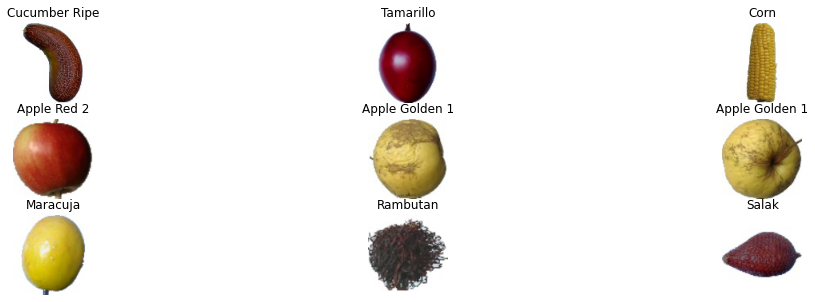

In [8]:
#Examples from the training set
show_example(train_dir)

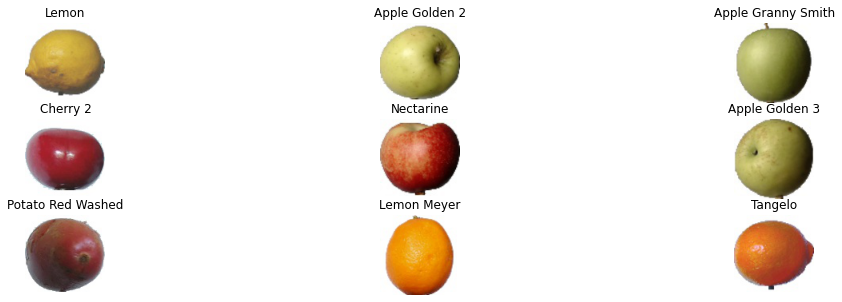

In [9]:
#Examples from the test set
show_example(test_dir)

## **Step2:Image generator**

In [10]:
IMAGE_SIZE=[224, 224]

**Image generator**

In [11]:
#image augmentation
train_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_val_generator = ImageDataGenerator(rescale=1./255,validation_split=0.4)
train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=50,
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 )

val_data = test_val_generator.flow_from_directory(test_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=10,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=True,
                                                  )


test_data = test_val_generator.flow_from_directory(test_dir,
                                                   target_size=IMAGE_SIZE,
                                                   batch_size=10,
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=False
                                                   )

Found 67692 images belonging to 131 classes.
Found 9016 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [12]:
for data_batch, labels_batch in train_data:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 131)


## **Step3:Training baseline model(Alexnet)**

**Baseline architecture(Alexnet)**

In [13]:
model_Alexnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11,11),strides=4, padding='valid', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (5,5),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3),strides=1, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [14]:
#summary of the imported Alexnet model
model_Alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

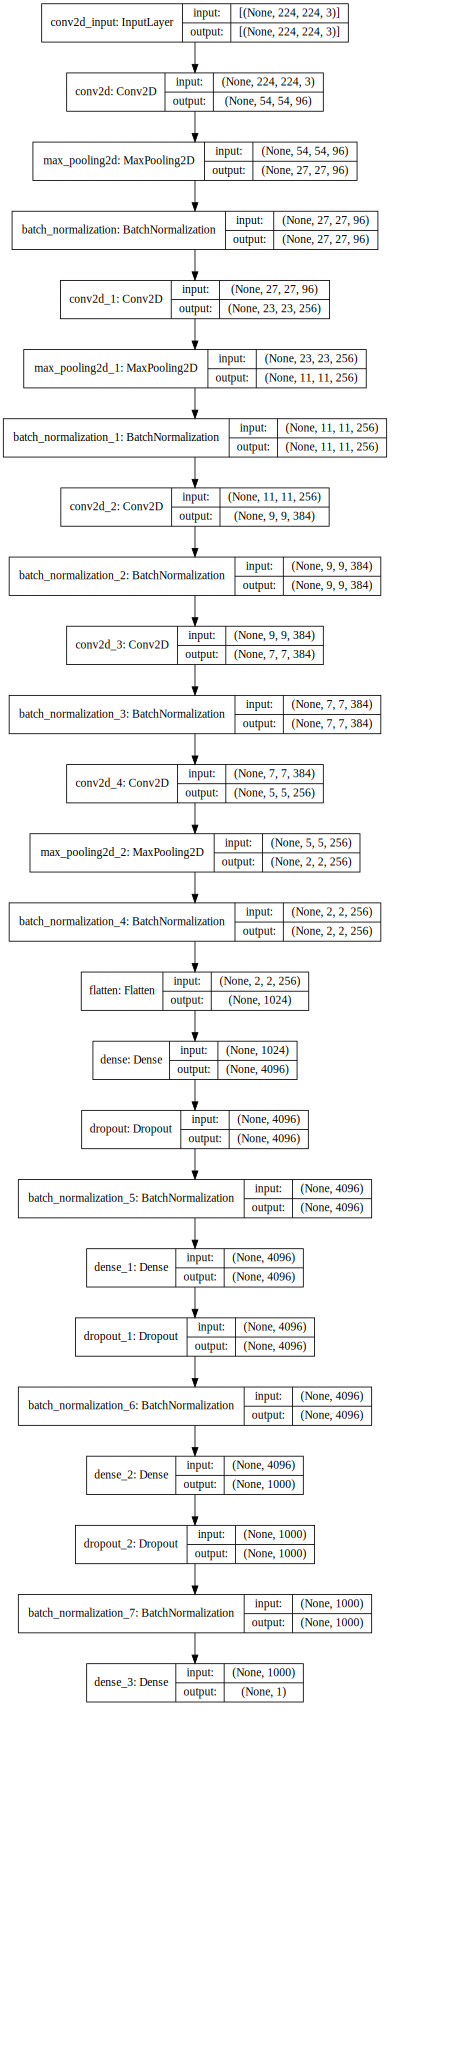

In [15]:
#Plot model 
SVG(model_to_dot(model_Alexnet, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

**Checkpoint**

Saving the snapshot of model as checkpoint

In [16]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, period=3)
filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

**Epochs**

In [17]:
#Set steps per epoch
# set steps per epoch for train
train_filenames = train_data.filenames
steps_train = len(train_filenames)/train_data.batch_size

# set steps per epoch for validation
val_filenames = val_data.filenames
steps_val = len(val_filenames)/val_data.batch_size

print(len(val_filenames), " ", steps_val)

9016   901.6


**Training baseline model(Alexnet)**

In [ ]:
#Alexnet Model Compilation
model_Alexnet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
#Fit the Alexnet model
history_Alexnet = model_Alexnet.fit(
        train_data,
        steps_per_epoch=steps_train,
        epochs=10,
        validation_data=val_data,
        callbacks = checkpoint,
        validation_steps=steps_val)

Epoch 1/10
1353/1353 [==============================] - 3565s 3s/step - loss: 2.6041 - acc: 0.5022 - val_loss: 19.3187 - val_acc: 0.9216
Epoch 2/10
1353/1353 [==============================] - 3615s 3s/step - loss: 0.8913 - acc: 0.5000 - val_loss: 26.7361 - val_acc: 0.9354
Epoch 3/10
1353/1353 [==============================] - 3659s 3s/step - loss: 0.3919 - acc: 0.4953 - val_loss: 26.8310 - val_acc: 0.8665
Epoch 4/10
1353/1353 [==============================] - 3644s 3s/step - loss: 0.2457 - acc: 0.4930 - val_loss: 38.3005 - val_acc: 0.9168
Epoch 5/10
1353/1353 [==============================] - 3680s 3s/step - loss: 0.1793 - acc: 0.4942 - val_loss: 58.6778 - val_acc: 0.9211
Epoch 6/10
1353/1353 [==============================] - 3698s 3s/step - loss: 0.1479 - acc: 0.4961 - val_loss: 54.0140 - val_acc: 0.9136
Epoch 7/10
1353/1353 [==============================] - 3687s 3s/step - loss: 0.1258 - acc: 0.4978 - val_loss: 80.2012 - val_acc: 0.9316
Epoch 8/10
1353/1353 [===================

**Save model**

In [ ]:
#Save model
model_Alexnet.save('Alexnet_frozen_model')

INFO:tensorflow:Assets written to: Alexnet_frozen_model/assets


## **Step4:Training Customized model**

**Customized Model and architecture**

In [48]:
#create model
model_Customized = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11,11),strides=4, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(384, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [49]:
#Customized Model summary
model_Customized.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 384)        

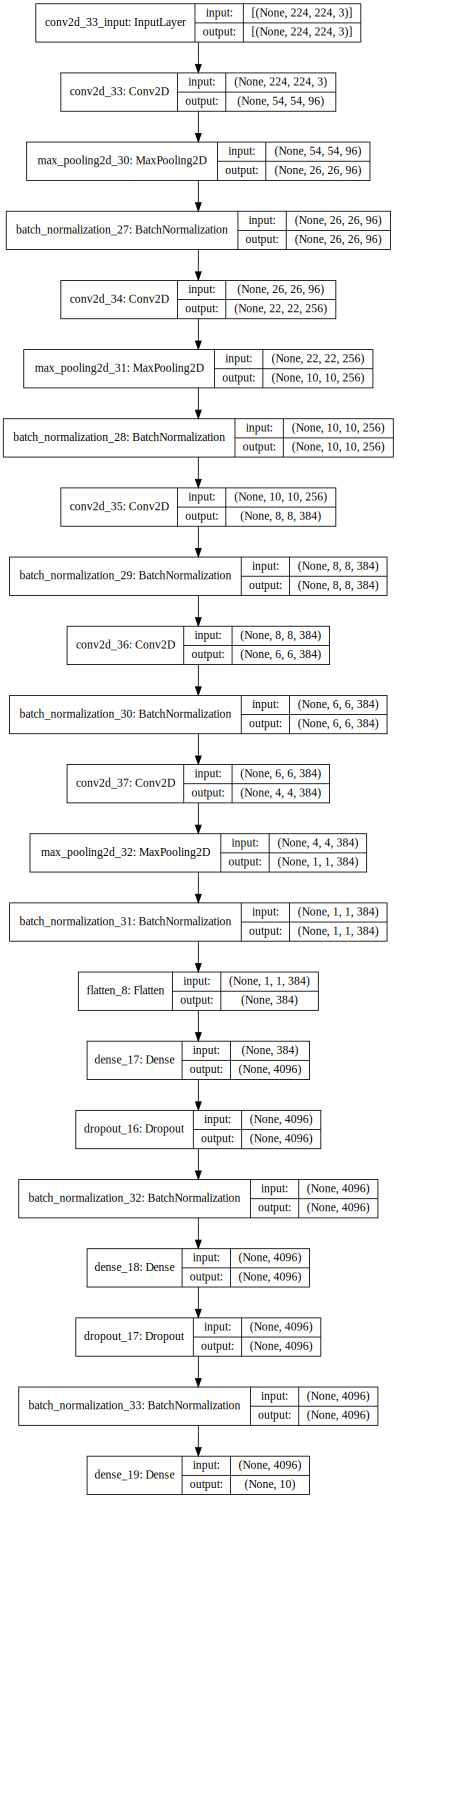

In [50]:
#Plot model 
SVG(model_to_dot(model_Customized, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

**Train Customiaed model**

In [51]:
#Customized Model Compilation
model_Customized.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [52]:
# Train the Customized model
history_Customized = model_Customized.fit(
        train_data,
        steps_per_epoch=steps_train,
        epochs=10,
        validation_data=val_data,
        callbacks = checkpoint,
        validation_steps=steps_val)

Epoch 1/10


InvalidArgumentError: ignored

## **Step5:Experimental Results**

**Alexnet Model**

In [ ]:
#evaluate and print test accuracy
score_Alexnet = model_Alexnet.evaluate(test_data, verbose=2)
print('\n', 'Alexnet Model Test accuracy:', score_Alexnet[1])

In [ ]:
#visualize the loss and accuracy wrt epochs
acc = history_Alexnet.history['acc']
val_acc = history_Alexnet.history['val_acc']
loss = history_Alexnet.history['loss']
val_loss = history_Alexnet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Alexnet Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Alexnet Model Training and validation loss')
plt.legend()

plt.show()

**Customized Model**

In [ ]:
#evaluate and print test accuracy
score_Customized = model_Customized.evaluate(test_data, verbose=0)
print('\n', 'Customized Model Test accuracy:', score_Customized[1])

In [ ]:
##visualize the loss and accuracy wrt epochs
acc = history_Customized.history['acc']
val_acc = history_Customized.history['val_acc']
loss = history_Customized.history['loss']
val_loss = history_Customized.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Customized Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Customized Training and validation loss')
plt.legend()

plt.show()

## **Step 5: Visualization of results**

In [ ]:
#creates X_train and Y_train using file_names and folders
def get_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

X_train, Y_train, labels = get_data(train_dir)
X_test, Y_test,_ = get_data(test_dir)

**Alexnet Model**

In [ ]:
#visualize Alexnet Model test prediction
y_pred = model_Alexnet.predict(test_data)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(test_data.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_data[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(test_data[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

**Customized Model**

In [ ]:
#visualize Customized Model test prediction
y_pred = model_Customized.predict(test_data)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(test_data.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_data[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(test_data[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))